### Question 2.1

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# === Black-box return generator ===
def draw_returns(N):
    normal_year = np.random.binomial(1, 0.9, N)

    mu = np.array([0.05, 0.05, 0.05])
    Sigma = np.array([[0.09, 0.012, 0.021], [0.012, 0.16, 0.028], [0.021, 0.028, 0.49]])
    normal_ret = np.random.multivariate_normal(mu, Sigma, N)

    mu = np.array([-0.1, -0.1, -0.1])
    Sigma = np.array([[0.36, 0.24, 0.42], [0.24, 0.64, 0.56], [0.42, 0.56, 1.96]])
    special_ret = np.random.multivariate_normal(mu, Sigma, N)

    ret = normal_ret
    for i in range(N):
        if normal_year[i] == 0:
            ret[i, :] = special_ret[i, :]
    return ret

# === Step 1: Simulate returns ===
N = 100_000
returns = draw_returns(N)
weights = np.array([0.3, 0.4, 0.3])
Wo = 10_000_000  # $10M portfolio

portfolio_returns = returns @ weights

# === Step 2: Compute VaR and CVaR ===
alpha = 0.01
VaR_alpha = -np.percentile(portfolio_returns, alpha * 100)
CVaR_alpha = -portfolio_returns[portfolio_returns <= np.percentile(portfolio_returns, alpha)].mean()

print(f"Portfolio VaR ({int((1-alpha)*100)}%): ${VaR_alpha * Wo:,.2f}")
print(f"Portfolio CVaR ({int((1-alpha)*100)}%): ${CVaR_alpha * Wo:,.2f}")

# === Step 3: Compute properly scaled Component CVaR ===
CVaR_cutoff = np.percentile(portfolio_returns, alpha * 100)
in_tail = portfolio_returns <= CVaR_cutoff

component_cvars = []
for i in range(3):
    cond_mean = returns[in_tail, i].mean()
    comp_cvar_i = -cond_mean * weights[i] * Wo
    component_cvars.append(comp_cvar_i)

component_cvars = np.array(component_cvars)

for i, val in enumerate(component_cvars):
    print(f"Component CVaR for Asset {chr(65+i)}: ${val:,.2f}")

print(f"Sum of Component CVaRs: ${component_cvars.sum():,.2f}")
print(f"Portfolio CVaR: ${CVaR_alpha * Wo:,.2f}")

# === Step 4: Compute DVaR using finite difference ===
h = 0.0001
DVaR = []

for i in range(3):
    perturbed_weights = weights.copy()
    perturbed_weights[i] += h
    perturbed_weights /= perturbed_weights.sum()
    perturbed_returns = returns @ perturbed_weights
    VaR_perturbed = -np.percentile(perturbed_returns, alpha * 100)
    marginal = (VaR_perturbed - VaR_alpha) / h
    DVaR.append(marginal)

DVaR = np.array(DVaR)
dollar_DVaR = DVaR * weights * Wo

for i, val in enumerate(dollar_DVaR):
    print(f"DVaR for Asset {chr(65+i)}: ${val:,.2f}")

print(f"Sum of DVaRs: ${dollar_DVaR.sum():,.2f}")
print(f"Total Portfolio VaR: ${VaR_alpha * Wo:,.2f}")


Portfolio VaR (99%): $10,784,608.25
Portfolio CVaR (99%): $26,896,022.26
Component CVaR for Asset A: $2,581,766.27
Component CVaR for Asset B: $4,973,402.67
Component CVaR for Asset C: $6,906,915.67
Sum of Component CVaRs: $14,462,084.61
Portfolio CVaR: $26,896,022.26
DVaR for Asset A: $-1,891,153.65
DVaR for Asset B: $-970,548.47
DVaR for Asset C: $2,861,702.11
Sum of DVaRs: $-0.00
Total Portfolio VaR: $10,784,608.25


### Decomposing the VaR of the Portfolio (99% Confidence)

The portfolio consists of 3 million dollars in asset A, 4 million in asset B, and 3 million in asset C, totaling 10 million dollars. Using simulated return draws and a 99% confidence level, we computed the portfolio's Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR), and then decomposed the risk into individual asset contributions.

Portfolio VaR (99%): 10,784,608.25  
Portfolio CVaR (99%): 26,896,022.26

These values represent the loss at the 1% quantile and the expected loss given that we are in the worst 1% of outcomes, respectively.

#### Component CVaR by Asset:

- Asset A: 2,581,766.27  
- Asset B: 4,973,402.67  
- Asset C: 6,906,915.67

Sum of component CVaRs: 14,462,084.61  
Portfolio CVaR: 26,896,022.26

The component CVaRs reflect each asset’s contribution to the portfolio’s total CVaR. From these values, it’s clear that asset C contributes the most to extreme portfolio losses.

#### DVaR (Marginal Contribution to VaR):

- Asset A: -1,891,153.65  
- Asset B: -970,548.47  
- Asset C: 2,861,702.11

Sum of DVaRs: ~0 (as expected)  
Portfolio VaR: 10,784,608.25

DVaRs show how much the portfolio VaR would change with a small increase in each asset’s weight. Again, asset C stands out as the biggest contributor to risk.

#### Final Remarks:

Both the component CVaR and DVaR results indicate that asset C is the primary contributor to portfolio risk, both in absolute tail exposure and in marginal impact. The decompositions align well with the total portfolio VaR and CVaR, so the calculations are consistent.


### Question 2.2

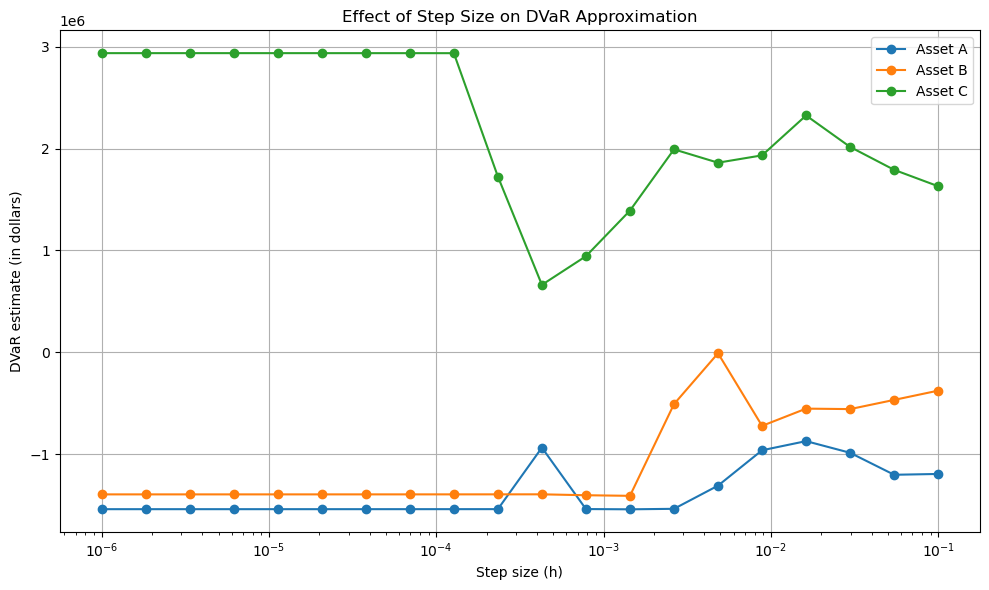

In [11]:
# --- Parameters ---
N = 100000
alpha = 0.01
Wo = 10_000_000
returns = draw_returns(N)
base_weights = np.array([0.3, 0.4, 0.3])
portfolio_returns = returns @ base_weights
VaR_base = -np.percentile(portfolio_returns, alpha * 100)

# --- Step sizes to test ---
step_sizes = np.logspace(-6, -1, 20)
dvar_matrix = np.zeros((3, len(step_sizes)))  # Store results for A, B, C

# --- Loop over assets and step sizes ---
for asset in range(3):
    for j, h in enumerate(step_sizes):
        perturbed_weights = base_weights.copy()
        perturbed_weights[asset] += h
        perturbed_weights /= perturbed_weights.sum()
        perturbed_returns = returns @ perturbed_weights
        VaR_perturbed = -np.percentile(perturbed_returns, alpha * 100)
        dvar_estimate = (VaR_perturbed - VaR_base) / h
        dvar_matrix[asset, j] = dvar_estimate * base_weights[asset] * Wo

# --- Plot all three assets ---
plt.figure(figsize=(10, 6))
labels = ['Asset A', 'Asset B', 'Asset C']
for i in range(3):
    plt.plot(step_sizes, dvar_matrix[i], marker='o', label=labels[i])

plt.xscale("log")
plt.xlabel("Step size (h)")
plt.ylabel("DVaR estimate (in dollars)")
plt.title("Effect of Step Size on DVaR Approximation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### : Sensitivity of DVaR to Step Size (h)

To estimate the DVaR for each asset, we used finite differences by slightly increasing the asset’s weight and observing the change in the portfolio's VaR. This method depends on the choice of the step size `h`, which controls how much the position is perturbed.

We varied the step size over a log scale from \( 10^{-6} \) to \( 10^{-1} \) and plotted the resulting DVaR estimates for all three assets. The graph shows that:

- For very **small values of h** (below \(10^{-4}\)), the DVaR estimates are relatively stable for each asset. This suggests that the numerical approximation is accurate in that range.
- However, for **very small h (e.g. \(10^{-6}\))**, floating-point precision issues may start to creep in, although it's not prominent here.
- As **h increases**, the estimates begin to fluctuate and become unreliable. This is because larger step sizes move too far from the base portfolio, violating the assumption of local linearity behind finite differences.
- **Asset C**, which contributes most to the overall risk, shows a particularly sharp drop and then rise in DVaR around \(10^{-3}\) to \(10^{-2}\). This highlights the instability caused by nonlinearity in the tail of the distribution when large perturbations are applied.

In short, the plot highlights a tradeoff:  
Too small a step may lead to numerical errors, while too large a step results in a poor approximation of the true derivative due to nonlinearities. A moderate step size (typically between \(10^{-4}\) and \(10^{-2}\)) gives the most consistent and accurate DVaR estimates.

This sensitivity analysis helps justify the choice of `h` in practical risk decomposition.


### Question 2.3

In [12]:
import numpy as np

# Parameters
N = 100000
alpha = 0.01
returns = draw_returns(N)

# Portfolio values
investment = np.array([3_000_000, 5_000_000, 2_000_000])
Wo = investment.sum()
weights = investment / Wo

# Portfolio return
portfolio_returns = returns @ weights
VaR_alpha = -np.percentile(portfolio_returns, alpha * 100)
CVaR_alpha = -portfolio_returns[portfolio_returns <= np.percentile(portfolio_returns, alpha)].mean()

# --- CVaR for Asset C ---
# E[R_C | R_p <= VaR]
VaR_cutoff = np.percentile(portfolio_returns, alpha * 100)
in_tail = portfolio_returns <= VaR_cutoff
expected_R_C_tail = returns[in_tail, 2].mean()
component_CVaR_C = -expected_R_C_tail * weights[2] * Wo

# --- DVaR for Asset C ---
h = 0.0001
perturbed_weights = weights.copy()
perturbed_weights[2] += h
perturbed_weights /= perturbed_weights.sum()
perturbed_returns = returns @ perturbed_weights
VaR_perturbed = -np.percentile(perturbed_returns, alpha * 100)
dvar_C = (VaR_perturbed - VaR_alpha) / h
dollar_DVaR_C = dvar_C * weights[2] * Wo

# Output
print(f"Component CVaR for Asset C: ${component_CVaR_C:,.2f}")
print(f"DVaR for Asset C: ${dollar_DVaR_C:,.2f}")


Component CVaR for Asset C: $4,105,662.27
DVaR for Asset C: $1,610,631.89


### CVaR and DVaR for Asset C (New Portfolio)

We change the portfolio allocation to:
- 3 million in asset A  
- 5 million in asset B  
- 2 million in asset C  
Total portfolio value: 10 million dollars

We compute both the CVaR and DVaR for **asset C** using the same methodology as before:

- **Component CVaR for Asset C**: 4,105,662.27  
  This reflects asset C’s contribution to the expected loss of the portfolio in the worst 1% of return scenarios.

- **DVaR for Asset C**: 1,610,631.89  
  This measures the marginal impact on portfolio VaR if we slightly increase the weight of asset C in the portfolio.

These values show that asset C continues to be a significant contributor to both the tail loss and the marginal risk of the portfolio under this new allocation.
